<font size="-0.1">

**<center><h1>Exploring Reinforcement Learning Methods to approximate the Lunar Lander problem</h1></center>**
**<center><h2>Advanced Reinforcement Learning Assignment (Actor Critic Experiment)</h2></center>**
**<center><h3>Matthias Bartolo</h3></center>**

</font>

**<h5>Package installation</h5>**

<font size="-0.1">

```pip
conda install swig
conda install nomkl
pip install gymnasium[all]
pip install ufal.pybox2d
pip install pygame
pip install renderlab
pip install numpy
pip install matplotlib
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118/torch_stable.html
```

</font>

**<h5>Package imports</h5>**

In [2]:
import os
import time
import renderlab as rl
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
import torch.optim as optim
from torch.optim import AdamW
%matplotlib inline
import matplotlib.pyplot as plt
from typing import Sequence
from collections import namedtuple, deque
import itertools
import random
import warnings
import copy
warnings.filterwarnings("ignore")

# Setting the device to cpu as it was faster than gpu for this task
device = torch.device("cpu")#torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print("CUDA is available, device is set to {}".format(device))

CUDA is available, device is set to cpu


**<h5>Declaring Hyperparameters</h5>**

In [6]:
# The learning rate α ∈ (0, 1] controls how much we update our current value estimates towards newly received returns.
ALPHA = 0.0003
# Gamma refers to the discount factor γ ∈ [0, 1]. It quantifies how much importance is given to future rewards.
GAMMA = 0.999
# Gamma refers to the discount factor γ ∈ [0, 1]. It quantifies how much importance is given to future rewards.
GAMMA_DDPG = 0.99
# The batch size is the number of training examples used in one iteration (that is, one gradient update) of training.
BATCH_SIZE = 64
# The buffer size is the number of transitions stored in the replay buffer, which the agent samples from to learn.
BUFFER_SIZE = 10000
# The minimum replay size is the minimum number of transitions that need to be stored in the replay buffer before the agent starts learning.
MIN_REPLAY_SIZE = 5000
# The tau value is the rate at which the target network is updated towards the online network τ ∈ [0, 1].
TAU = 0.01
# The maximum replay size is the maximum number of transitions that can be stored in the replay buffer.
MAX_REPLAY_SIZE = 50
# Epsilon is the probability of selecting a random action instead of the greedy action.
EPSILON = 0.2
# The success criteria is the average reward over the last 50 episodes that the agent must achieve to be considered successful.
SUCCESS_CRITERIA = 195
# The number of environments to run in parallel
NUM_ENVS = 8
# The number of neurons in the hidden layer
HIDDEN_SIZE = 64
# The number of steps to run the running memory for
MEM_STEPS = 1024
# The number of epochs to run the training for
EPOCH_REPEAT = 4
# The lambda value for the generalized advantage estimation
LAMBDA = 0.98
# To float tensor and to int tensor conversion functions
to_float_tensor = lambda x: torch.as_tensor(x, dtype=torch.float32).to(device)
to_int_tensor = lambda x: torch.as_tensor(x, dtype=torch.int64).to(device)

**<h5>Environment Setup</h5>**

In [19]:
# Creating the "LunarLanderContinuous-v2" environment from gymnasium with the render mode set to rgb_array and the number of environments set to NUM_ENVS
env = gym.vector.make("LunarLanderContinuous-v2", render_mode="rgb_array", num_envs=NUM_ENVS, asynchronous=False)

# Resetting the environment
env.reset()

(array([[ 5.4714205e-03,  1.4204787e+00,  5.5418426e-01,  4.2481205e-01,
         -6.3332613e-03, -1.2553100e-01,  0.0000000e+00,  0.0000000e+00],
        [ 9.9401479e-04,  1.4000423e+00,  1.0067000e-01, -4.8346311e-01,
         -1.1450492e-03, -2.2803267e-02,  0.0000000e+00,  0.0000000e+00],
        [ 3.2806396e-03,  1.4056354e+00,  3.3228090e-01, -2.3487581e-01,
         -3.7946829e-03, -7.5266428e-02,  0.0000000e+00,  0.0000000e+00],
        [ 1.3447761e-03,  1.4055741e+00,  1.3619873e-01, -2.3759750e-01,
         -1.5515111e-03, -3.0851021e-02,  0.0000000e+00,  0.0000000e+00],
        [-2.4595261e-03,  1.4011838e+00, -2.4913375e-01, -4.3272462e-01,
          2.8567121e-03,  5.6432497e-02,  0.0000000e+00,  0.0000000e+00],
        [-1.4352798e-04,  1.4068953e+00, -1.4554446e-02, -1.7888692e-01,
          1.7310021e-04,  3.2968111e-03,  0.0000000e+00,  0.0000000e+00],
        [ 4.9585341e-03,  1.4073743e+00,  5.0223714e-01, -1.5760042e-01,
         -5.7389732e-03, -1.1376409e-01,  0.0

In [3]:
# Creating the "LunarLanderContinuous-v2" environment from gymnasium with the render mode set to rgb_array
single_env = gym.make("LunarLanderContinuous-v2", render_mode="rgb_array")

# Resetting the environment
single_env.reset()

(array([ 0.00742674,  1.4032108 ,  0.7522217 , -0.34266645, -0.00859882,
        -0.17038943,  0.        ,  0.        ], dtype=float32),
 {})

**<h5>Visualising Observation Space</h5>**

In [4]:
# Checking the observation space
obs, info = env.reset()

print("The observation space consists of a Box of shape {}".format(obs.shape))

# Setting observation space to the first observation
obs = obs[0]
print('\033[1m' + "A single observation space consists of the following values:" + '\033[0m')
print('\033[37m' + 'X position: ' + '\033[0m' + obs[0].astype(str))
print('\033[36m' + 'Y position: ' + '\033[0m' + obs[1].astype(str))
print('\033[35m' + 'X velocity: ' + '\033[0m' + obs[2].astype(str))
print('\033[34m' + 'Y velocity: ' + '\033[0m' + obs[3].astype(str))
print('\033[33m' + 'Angle: ' + '\033[0m' + obs[4].astype(str))
print('\033[32m' + 'Angular velocity: ' + '\033[0m' + obs[5].astype(str))
print('\033[31m' + 'Left leg touching the ground (0 or 1): ' + '\033[0m' + obs[6].astype(str))
print('\033[1m' + 'Right leg touching the ground (0 or 1): ' + '\033[0m' + obs[7].astype(str))

The observation space consists of a Box of shape (8, 8)
A single observation space consists of the following values:
X position: 0.0038215637
Y position: 1.420887
X velocity: 0.38707548
Y velocity: 0.4429633
Angle: -0.004421532
Angular velocity: -0.08767838
Left leg touching the ground (0 or 1): 0.0
Right leg touching the ground (0 or 1): 0.0


**<h5>Visualising Action Space</h5>**

In [5]:
# Checking the action space
action_space = env.action_space

print("The action space consists of a Box of shape {}".format(action_space.shape))
print('\033[1m' + "The action space consists of the following values:" + '\033[0m')
print('\033[35m' + 'Value 1 (Thrust): (-1.0, 1.0) for the main engine, whereby: ' + '\033[0m')
print('\033[35m' + '[-1.0, -0.5] is off' + '\033[0m')
print('\033[35m' + '[0.5, 1.0] is on' + '\033[0m')
print()
print('\033[34m' + 'Value 2 (Rotation): (-1.0, 1.0) whereby:' + '\033[0m')
print('\033[34m' + '[-1.0, -0.5] is left' + '\033[0m')
print('\033[34m' + '[0.5, 1.0] is right' + '\033[0m')
print('\033[34m' + '[-0.5, 0.5] is off' + '\033[0m')

The action space consists of a Box of shape (8, 2)
The action space consists of the following values:
Value 1 (Thrust): (-1.0, 1.0) for the main engine, whereby: 
[-1.0, -0.5] is off
[0.5, 1.0] is on

Value 2 (Rotation): (-1.0, 1.0) whereby:
[-1.0, -0.5] is left
[0.5, 1.0] is right
[-0.5, 0.5] is off


**<h4> PPO Implementation </h4>**

**<h5>Actor Network</h5>**

In [20]:
class ActorNet(nn.Module):
    """
        Actor network for the PPO algorithm

        Args:
            input_size (int): The number of input features
            hidden_units (int): The number of hidden units
            output_size (int): The number of output features

        Layers:
            1. Linear layer with input_size and hidden_units
            2. Tanh activation function
            3. Linear layer with hidden_units and int(hidden_units/2)
            4. Tanh activation function
            5. Linear layer with int(hidden_units/2) and output_size
            6. Linear layer with int(hidden_units/2) and output_size
        
    """
    def __init__(self, input_size, hidden_units=64, output_size=2):
        super(ActorNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.Tanh()
        )

        # The mu_head is the mean of the normal distribution
        self.mu_head = nn.Linear(int(hidden_units/2),  output_size)

        # The logstd_head is the standard deviation of the normal distribution
        self.logstd_head = nn.Linear(int(hidden_units/2),  output_size)

    def forward(self, x):
        x = self.model(x)

        # The mean is scaled by 2 and the standard deviation is exponentiated
        loc = torch.tanh(self.mu_head(x)) * 2

        # The standard deviation is exponentiated
        scale = torch.exp(self.logstd_head(x))

        # Returning the mean and standard deviation
        return loc, scale

    def __call__(self, x):
        out = self.forward(x)
        return out

**<h5>Critic Network</h5>**

In [21]:
class CriticNet(nn.Module):
    """
        Critic network for the PPO algorithm

        Args:
            input_size (int): The number of input features
            hidden_units (int): The number of hidden units

        Layers:
            1. Linear layer with input_size and hidden_units
            2. Tanh activation function
            3. Linear layer with hidden_units and int(hidden_units/2)
            4. Tanh activation function
            5. Linear layer with int(hidden_units/2) and output_size
        
    """
    def __init__(self, input_size, hidden_units=64):
        super(CriticNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.Tanh(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.Tanh()
        )

        # The value_head is the value of the state action pair
        self.value_head = nn.Linear(int(hidden_units/2), 1)

    def forward(self, x):
        x = self.model(x)
        value = self.value_head(x)
        return value

    def __call__(self, x):
        out = self.forward(x)
        return out

**<h5>Running Memory</h5>**

In [22]:
class RunningMemory():
    """
        Running memory for the PPO algorithm

    """
    def __init__(self):
        self.reset()

    def store(self, obs, action, logprob, reward, done, obs_, values, values_):
        """
            Stores the data in the running memory

            Args:
                obs (torch.Tensor): The observation
                action (torch.Tensor): The action
                logprob (torch.Tensor): The log probability
                reward (torch.Tensor): The reward
                done (torch.Tensor): The done flag
                obs_ (torch.Tensor): The next observation
                values (torch.Tensor): The value of the state action pair
                values_ (torch.Tensor): The value of the next state action pair

        """
        self.obs.append(obs)
        self.actions.append(action.unsqueeze(-1))
        self.logprobs.append(logprob)
        self.rewards.append(reward.unsqueeze(-1))
        self.dones.append(done.unsqueeze(-1))
        self.obs_.append(obs_)
        self.values.append(values)
        self.values_.append(values_)


    def batches(self, batchsize):
        """
            Returns the batches from the running memory

            Args:
                batchsize (int): The size of the batch

            Returns:
                mb_obs (torch.Tensor): The observation
                mb_actions (torch.Tensor): The action
                mb_logprobs (torch.Tensor): The log probability
                mb_rewards (torch.Tensor): The reward
                mb_dones (torch.Tensor): The done flag
                mb_obs_ (torch.Tensor): The next observation
                mb_values (torch.Tensor): The value of the state action pair
                mb_values_ (torch.Tensor): The value of the next state action pair
                mb_gae (torch.Tensor): The generalized advantage estimation

        """
        # Determining the size of the running memory
        size = NUM_ENVS*MEM_STEPS

        # Creating a list of indices
        idx = list(range(size))

        # Shuffling the indices
        random.shuffle(idx)

        # Creating a tensor index for the indices
        b_obs = torch.stack(self.obs).to(device)
        b_actions = torch.stack(self.actions).to(device)
        b_logprobs = torch.stack(self.logprobs).to(device)
        b_rewards = torch.stack(self.rewards).to(device)
        b_dones = torch.stack(self.dones).to(device)
        b_obs_ = torch.stack(self.obs_).to(device)
        b_values = torch.stack(self.values).to(device)
        b_values_ = torch.stack(self.values_).to(device)

        # Creating a generalized advantage estimation (GAE)
        gaes = []

        # Creating a tensor of zeros for the GAE
        gae = to_float_tensor(np.zeros(NUM_ENVS)).view(NUM_ENVS,-1)

        # Iterating through the running memory in reverse
        for i in range(len(b_obs)-1,-1,-1):
            # Calculating the delta value (δ = r + γV(s') - V(s))
            delta = b_rewards[i] + GAMMA * b_values_[i] * (1-b_dones[i]) - b_values[i]

            # Calculating the GAE (δ + γλ(1-d)GAE)
            gae = delta + GAMMA * LAMBDA * (1-b_dones[i]) * gae

            # Appending the GAE to the list of GAEs
            gaes.insert(0, gae)

        # Converting the list of GAEs to a tensor
        b_obs = b_obs.view(size, -1)
        b_actions = b_actions.view(size, -1)
        b_logprobs = b_logprobs.view(size, -1)
        b_rewards = b_rewards.view(size, -1)
        b_dones = b_dones.view(size, -1)
        b_obs_ = b_obs_.view(size, -1)
        b_values = b_values.view(size, -1)
        b_values_ = b_values_.view(size, -1)
        b_gae = torch.stack(gaes).view(size, -1)

        # Iterating through the batches
        for batchn in range(0, len(idx), batchsize):
            # Creating a tensor index for the batch indices
            batchidx = idx[batchn:batchn+batchsize]
            batchidx = to_int_tensor(batchidx)
            mb_obs = torch.index_select(b_obs, 0, batchidx).to(device)
            mb_actions = torch.index_select(b_actions, 0, batchidx).to(device)
            mb_logprobs = torch.index_select(b_logprobs, 0, batchidx).to(device)
            mb_rewards = torch.index_select(b_rewards, 0, batchidx).to(device)
            mb_dones = torch.index_select(b_dones, 0, batchidx).to(device)
            mb_obs_ = torch.index_select(b_obs_, 0, batchidx).to(device)
            mb_values = torch.index_select(b_values, 0, batchidx).to(device)
            mb_values_ = torch.index_select(b_values_, 0, batchidx).to(device)
            mb_gae = torch.index_select(b_gae, 0, batchidx).to(device)

            # Yielding the batches
            yield mb_obs, mb_actions, mb_logprobs, mb_rewards, mb_dones, mb_obs_, mb_values, mb_values_, mb_gae

    def reset(self):
        """
            Resets the running memory

        """
        self.obs = []
        self.actions = []
        self.logprobs = []
        self.rewards = []
        self.dones = []
        self.obs_ = []
        self.values = []
        self.values_ = []
        self.gae = []

**<h5>PPO GAE2 Agent</h5>**

In [23]:
class PPOGAE2Agent():
    """
        PPOGAE2Agent class

        Args:
            env (gym.Env): The environment
            running_memory (RunningMemory): The running memory
            actor_net (nn.Module): The actor network
            critic_net (nn.Module): The critic network
            hidden_size (int): The number of neurons in the hidden layer
            actor_lr (float): The learning rate for the actor network
            critic_lr (float): The learning rate for the critic network
            num_envs (int): The number of environments to run in parallel
            actor_optimizer (torch.optim): The optimizer for the actor network
            critic_optimizer (torch.optim): The optimizer for the critic network
            criterion (torch.nn): The loss function
            name (str): The name of the agent

        Attributes:
            env (gym.Env): The environment
            running_memory (RunningMemory): The running memory
            ninputs (int): The number of input features
            noutputs (int): The number of output features
            hidden_size (int): The number of neurons in the hidden layer
            actor_lr (float): The learning rate for the actor network
            critic_lr (float): The learning rate for the critic network
            criterion (torch.nn): The loss function
            actor_net (nn.Module): The actor network
            critic_net (nn.Module): The critic network
            actor_optimizer (torch.optim): The optimizer for the actor network
            critic_optimizer (torch.optim): The optimizer for the critic network
            epsilon (float): The probability of selecting a random action instead of the greedy action
            steps_done (int): The number of steps done
            episodes (int): The number of episodes
            num_envs (int): The number of environments to run in parallel
            episode_info (dict): The episode information
            display_every_n_episodes (int): The number of episodes to display the information for

    """
    def __init__(self, env, running_memory, actor_net, critic_net, hidden_size=HIDDEN_SIZE, actor_lr=ALPHA, critic_lr=ALPHA, num_envs=NUM_ENVS, actor_optimizer=AdamW, critic_optimizer=AdamW, criterion=nn.SmoothL1Loss(), name="PPO"):
        self.env = env
        self.running_memory = running_memory
        self.ninputs = env.observation_space.shape[0]
        self.noutputs = env.action_space.shape[0]
        self.hidden_size = hidden_size
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.criterion = criterion
        self.actor_net = actor_net(self.ninputs, self.hidden_size, self.noutputs).to(device)
        self.critic_net = critic_net(self.ninputs, self.hidden_size).to(device)

        # Applying the initialize_weights function to the actor and critic networks
        self.actor_net.apply(self.initialize_weights)
        self.critic_net.apply(self.initialize_weights)

        # Creating the optimizer for the actor and critic networks
        self.actor_optimizer = actor_optimizer(self.actor_net.parameters(), lr=self.actor_lr)
        self.critic_optimizer = critic_optimizer(self.critic_net.parameters(), lr=self.critic_lr)

        self.epsilon = EPSILON
        self.steps_done = 0
        self.episodes = 0
        self.num_envs = num_envs
        self.episode_info = {"name":name, "episode_avg_rewards": {}, "episode_lengths": [], "solved": False, "eps_duration": 0}
        self.display_every_n_episodes = 10
        
    def initialize_weights(self, layer):
        """
            Initializes the weights of the layers of the actor and critic networks

            Args:
                layer (nn.Module): The layer to initialize the weights of
        """
        # Checking if the layer is a linear layer
        if isinstance(layer, nn.Conv2d):
            # Initializing the weights of the layer using the Xavier normal initialization
            nn.init.xavier_normal_(layer.weight.data, nonlinearity='relu')

            # Initializing the bias of the layer to 0 if it exists
            if layer.bias is not None:
                # Initializing the bias of the layer to 0
                nn.init.constant_(layer.bias.data, 0)

        # Checking if the layer is a batch normalization layer
        elif isinstance(layer, nn.BatchNorm2d):
            # Initializing the weights of the layer to 1
            nn.init.constant_(layer.weight.data, 1)

            # Initializing the bias of the layer to 0
            nn.init.constant_(layer.bias.data, 0)

        # Checking if the layer is a linear layer
        elif isinstance(layer, nn.Linear):
            # Initializing the weights of the layer using the Xavier normal initialization
            nn.init.xavier_normal_(layer.weight.data)

            # Initializing the bias of the layer to 0 if it exists
            nn.init.constant_(layer.bias.data, 0)


    @torch.no_grad()
    def sim_action(self, policy, obs):
        """
            Simulates an action using the policy

            Args:
                policy (nn.Module): The policy
                obs (torch.Tensor): The observation
        """
        # Getting the mean and standard deviation from the policy
        loc, std = policy(to_float_tensor(obs))

        # Creating a normal distribution from the mean and standard deviation
        dist = Normal(loc=loc, scale=std+1e-6)

        # Sampling an action from the normal distribution
        action = dist.sample()

        # Calculating the log probability of the action
        action_log_prob = torch.sum(dist.log_prob(action), dim=-1, keepdim=True)

        # Returning the action and the log probability of the action
        return action, action_log_prob

    def train(self):
        """
            Trains the agent

        """
        # Iterating through the epochs
        for epochrep in range(EPOCH_REPEAT):
            # Iterating through the batches
            for batch in self.running_memory.batches(batchsize=BATCH_SIZE):
                # Getting the observation, action, log probability, reward, done flag, next observation, value of the state action pair, value of the next state action pair and generalized advantage estimation from the batch
                obs, actions, logprobs, rewards, dones, obs_, values, values_, gae = batch

                # Normalizing the generalized advantage estimation
                gae = (gae - torch.mean(gae).to(device)) / (torch.std(gae) + 1e-6).to(device)
                # gae = (gae - torch.mean(gae)) / (torch.std(gae) + 1e-6)

                # Calculating the target value
                target = gae + values

                # Getting the state values from the critic network
                state_values = self.critic_net(obs)

                # Calculating the critic loss
                critic_loss = self.criterion(state_values, target).mean()

                # Getting the mean and standard deviation from the actor network
                new_loc, new_scale = self.actor_net(obs)

                # Creating a normal distribution from the mean and standard deviation
                dist = Normal(loc=new_loc, scale=new_scale+1e-6)

                # Calculating the log probability of the action
                new_logprobs = torch.sum(dist.log_prob(actions), dim=-1, keepdim=True)

                # Calculating the importance sampling ratio (ρ = exp(logπ(a|s) - logπold(a|s))) (Policy Update Ratio)
                rho = torch.exp(new_logprobs - logprobs).to(device)

                # Calculating the surrogate 1 (L1(θ) = ρ * GAE) (Policy Update Ratio * Advantage)
                surrgt1 = rho * gae

                # Calculating the surrogate 2 (L2(θ) = ρ * clip(1-ε, 1+ε) * GAE) (Clipping)
                surrgt2 = rho.clamp(1-self.epsilon, 1+self.epsilon) * gae

                # Calculating the policy loss (-min(L1(θ), L2(θ))) (Minimum)
                policy_loss = -torch.minimum(surrgt1, surrgt2).mean().to(device)

                # Calculating the loss
                loss = policy_loss + 0.5*critic_loss

                # Zeroing the gradients of the actor and critic networks
                self.actor_optimizer.zero_grad()
                self.critic_optimizer.zero_grad()

                # Backpropagating the loss
                loss.backward()

                # Updating the weights of the actor and critic networks
                self.actor_optimizer.step()
                self.critic_optimizer.step()

    def run(self):
        """
            Runs the agent

        """
        # Creating a deque for the results
        results = deque(maxlen=MAX_REPLAY_SIZE)

        # Creating a tensor of zeros for the total reward
        total_reward = np.zeros(self.num_envs)

        # Creating a dictionary for the episode information
        for i in range(self.num_envs):
            self.episode_info["episode_avg_rewards"][i] = []
       
        # Declaring the step count
        step_count = 0

        # Declaring the episode count
        episode_count = 0

        # Resetting the environment
        obs, _ = self.env.reset()

        # Calculating the start time
        start_time = time.time()

        # Iterating until the environment is solved
        while True:
            # Incrementing the step count
            step_count += 1

            # Simulating an action using the actor network
            action, action_log_prob = self.sim_action(self.actor_net, obs)

            # Taking a step in the environment
            next_obs, reward, terminated, truncated, _ = self.env.step(action.cpu().numpy())

            # Setting the done flag
            done = terminated | truncated

            # Retrieving the state value from the critic network
            with torch.no_grad():
                values = self.critic_net(to_float_tensor(obs))
                values_ = self.critic_net(to_float_tensor(next_obs))

            # Storing the data in the running memory
            self.running_memory.store(to_float_tensor(obs), action, action_log_prob, to_float_tensor(reward), to_int_tensor(done), to_float_tensor(next_obs), values, values_)

            # Setting the observation to the next observation
            obs = next_obs

            # Adding the reward to the total reward
            total_reward += reward

            # Getting the indices of the environments that are done
            doneidx = np.where(done==True)

            # Iterating through the done indices
            for k in doneidx[0]:
                # Appending the total reward to the results
                results.append(total_reward[k])

                # Resetting the total reward
                total_reward[k] = 0

            # Checking if the step count is greater than 1 and the step count is a multiple of the memory steps
            if step_count>1 and step_count % MEM_STEPS == 0:
                # Incrementing the episode count
                episode_count+=1

                # Training the agent
                self.train()

                # Resetting the running memory
                self.running_memory.reset()

                # Appending the average episode reward for each environment to the episode information
                for i in range(self.num_envs):
                    self.episode_info["episode_avg_rewards"][i].append(total_reward[i])

                # Appending the episode length
                self.episode_info["episode_lengths"].append(step_count)
                
                # Checking if the episode count is a multiple of the display every n episodes
                if episode_count % self.display_every_n_episodes == 0:
                    
                    # Printing the episode information
                    print('\033[35mEpisode:\033[0m {} \033[35mEpsilon:\033[0m {:.2f} \033[35mAverage Reward:\033[0m {} \033[35mEpisode Length:\033[0m {}'
                          .format(episode_count, self.epsilon, np.mean(results), step_count))
                    print('-'*100)

                # Checking if the success criteria is met
                if len(results)>0 and min(results) > SUCCESS_CRITERIA:
                    # Printing that the environment is solved
                    print('\033[32mSolved!\033[0m')

                    # Setting the solved flag to True
                    self.episode_info["solved"] = True

                    # Breaking out of the loop
                    break

        # Calculating the end time
        end_time = time.time()

        # Calculating the duration
        duration = end_time - start_time

        # Setting the duration in the episode information
        self.episode_info["eps_duration"] = duration

    def test(self, num_test_runs=100):
        """
            Tests the agent

            Args:
                num_test_runs (int): The number of test runs
        """
        # Declaring the optimal environment
        optimal_env = None
        optimal_env_counter = -1

        # Declaring the maximum average reward
        max_average_reward = float('-inf')

        # Iterating through the environments
        for counter, env in enumerate(self.env.envs):

            # Declaring the total rewards
            total_rewards = []

            # Iterating through the test runs
            for _ in range(num_test_runs):
                # Resetting the environment
                obs, _ = env.reset()

                # Declaring the done flag
                done = False

                # Declaring the total reward
                total_reward = 0

                # Iterating until the environment is done
                while not done:
                    # Simulating an action using the actor network
                    action, action_log_prob = self.sim_action(self.actor_net, obs)

                    # Taking a step in the environment
                    obs, reward, terminated, truncated, _ = env.step(action.cpu().numpy())

                    # Setting the done flag
                    done = terminated or truncated

                    # Adding the reward to the total reward
                    total_reward += reward

                # Appending the total reward to the total rewards
                total_rewards.append(total_reward)

            # Calculating the average reward
            average_reward = sum(total_rewards) / num_test_runs

            # Printing the average reward
            print('\033[37mEnvironment:\033[0m {} \033[35mAverage Reward:\033[0m {}'.format(counter, average_reward))

            # Checking if the average reward is greater than the maximum average reward
            if average_reward > max_average_reward:
                # Setting the maximum average reward to the average reward
                max_average_reward = average_reward

                # Setting the optimal environment to the environment
                optimal_env = env

                # Setting the optimal environment counter to the counter
                optimal_env_counter = counter

        print('-'*100)
        # Printing the optimal environment and the maximum average reward
        print('\033[37mOptimal Environment:\033[0m {} \033[35mMaximum Average Reward:\033[0m {}'.format(optimal_env_counter, max_average_reward))

        # Rendering a video of the optimal environment
        self.render_video(optimal_env)

        # Returning the average reward
        return optimal_env, max_average_reward


    def render_video(self, env):
        """
            Renders a video of the trained agent
        """
        # Importing renderlab
        import renderlab as rl

        # Setting renderlab
        env = rl.RenderFrame(env, "./video")

        # Declaring the done flag
        done = False

        # Resetting the environment
        obs, _ = env.reset()

        # Iterating until the environment is done
        while not done:
            # Rendering the environment
            env.render()

            # Simulating an action using the actor network
            action, action_log_prob = self.sim_action(self.actor_net, obs)

            # Taking a step in the environment
            obs, _, terminated, truncated, _  = env.step(action.cpu().numpy())

            # Setting the done flag
            if terminated or truncated:
                break

        # Playing the video
        env.play()

    def save_model(self, path):
        """
            Saves the model

            Args:
                path (str): The path to save the model to
        """
        # Creating the directory if it does not exist
        if not os.path.exists(path):
            os.makedirs(path)

        # Saving the actor and critic networks
        torch.save(self.actor_net.state_dict(), path + "/actor_net.pt")
        torch.save(self.critic_net.state_dict(), path + "/critic_net.pt")

        # Saving the episode information
        np.save(path + "/episode_info.npy", self.episode_info)

    def load_model(self, path):
        """
            Loads the model

            Args:
                path (str): The path to load the model from
        """
        # Loading the actor and critic networks
        self.actor_net.load_state_dict(torch.load(path + "/actor_net.pt"))
        self.critic_net.load_state_dict(torch.load(path + "/critic_net.pt"))

        # Loading the episode information
        self.episode_info = np.load(path + "/episode_info.npy", allow_pickle=True).item()

    def get_episode_info(self):
        """Returns the episode info """
        return self.episode_info

**<h5>Training PPO GAE2 Agent</h5>**

In [10]:
# Setting name
name = "PPOGAE2"

# Creating the RunningMemory
running_memory = RunningMemory()

# Creating the PPOGAE2Agent
ppo_gae2_agent = PPOGAE2Agent(env, running_memory, ActorNet, CriticNet, name=name)

# Running the agent
ppo_gae2_agent.run()

# Retrieving the episode info
ppo_gae2_episode_info = ppo_gae2_agent.get_episode_info()

# Printing the time taken to train the agent

print("Time taken to train the agent: {:.2f} seconds".format(ppo_gae2_episode_info["eps_duration"]))

# Saving the model
ppo_gae2_agent.save_model(path="models/" + name)

Episode: 10 Epsilon: 0.20 Average Reward: -251.85947578988916 Episode Length: 10240
----------------------------------------------------------------------------------------------------
Episode: 20 Epsilon: 0.20 Average Reward: -128.08473896118664 Episode Length: 20480
----------------------------------------------------------------------------------------------------
Episode: 30 Epsilon: 0.20 Average Reward: -82.73507792091996 Episode Length: 30720
----------------------------------------------------------------------------------------------------
Episode: 40 Epsilon: 0.20 Average Reward: -35.863058927643976 Episode Length: 40960
----------------------------------------------------------------------------------------------------
Episode: 50 Epsilon: 0.20 Average Reward: -19.844358977630826 Episode Length: 51200
----------------------------------------------------------------------------------------------------
Episode: 60 Epsilon: 0.20 Average Reward: -1.8877488877419097 Episode Length

**<h4> DDPG Implementation </h4>**



**<h5>Policy / Actor Network</h5>**

In [4]:
class PolicyNet(nn.Module):
    """
        Policy network for the DDPG algorithm

        Args:
            input_size (int): The number of input features
            hidden_units (int): The number of hidden units
            output_size (int): The number of output features
            pmin (float): The minimum action value
            pmax (float): The maximum action value

        Layers:
            1. Linear layer with input_size and hidden_units
            2. ReLU activation function
            3. Linear layer with hidden_units and int(hidden_units/2)
            4. ReLU activation function
            5. Linear layer with int(hidden_units/2) and output_size
            6. Tanh activation function
    
    """
    def __init__(self, input_size, hidden_units, output_size, pmin, pmax):
        super(PolicyNet, self).__init__()
        self.pmin = pmin
        self.pmax = pmax
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_units/2), output_size),
            nn.Tanh()
        )

    def forward(self, x):
        # Scaling the output of the model to the range [pmin, pmax]
        x = self.model(x) * self.pmax

        # Clipping the output of the model to the range [pmin, pmax]
        torch.clip_(x, self.pmin, self.pmax)
        
        # Returning the output of the model
        return x

    def __call__(self, x):
        out = self.forward(x)
        return out

**<h5>Value / Critic Network</h5>**

In [5]:
class DQN(nn.Module):
    """
        Critic network (DQN) for the DDPG algorithm

        Args:
            ninputs: The number of inputs
            noutputs: The number of outputs

        Layers:
            1. Linear layer with ninputs and hidden_units
            2. ReLU activation function
            3. Linear layer with hidden_units and int(hidden_units/2)
            4. ReLU activation function
            5. Linear layer with int(hidden_units/2) and 1
    """
    def __init__(self, input_size, hidden_units):
        super(DQN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, int(hidden_units/2)),
            nn.ReLU(),
            nn.Linear(int(hidden_units/2), 1)
        )

    def forward(self, state, action):
        # Concatenating the state and action
        x = torch.cat([state, action], 1)

        # Getting the Q value from the model
        x = self.model(x)

        # Returning the Q value
        return x

    def __call__(self, state, action):
        out = self.forward(state, action)
        return out

**<h5> Ornstein-Uhlenbeck Action Noise Generator </h5>**

In [6]:
class ActionNoise(object):
    """
        Random noise generator: Taken from OpenAI baselines
    """
    def reset(self):
        pass

class OrnsteinUhlenbeckActionNoise(ActionNoise):
    """
        Ornstein-Uhlenbeck process: Taken from OpenAI baselines

        Args:
            mu (torch.Tensor): The mean of the noise (np.zeros(1))
            sigma (torch.Tensor): The standard deviation for the noise (0.2 * np.ones(1))
            theta (float): The theta value (0.15)
            dt (float): The dt value (1e-2)
            x0 (torch.Tensor): The initial value for the noise (None)

    """
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        # Calculating the noise value (x = x + θ(μ - x)dt + σ√dt * N(0,1))
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)

        # Setting the previous value to the current value
        self.x_prev = x

        # Returning the noise value
        return x

    def reset(self):
        # Setting the previous value to the initial value
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        # Returning the string representation of the Ornstein-Uhlenbeck process
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

**<h5>Replay Buffer</h5>**

In [7]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'done', 'next_state'))

class Replay_Buffer():
    """
        The replay buffer stores the transitions that the agent observes, allowing us to reuse this data later.

        Args:
            env: The environment to interact with
            fullsize: The maximum size of the replay buffer
            minsize: The minimum size of the replay buffer before the agent starts learning
            batchsize: The batch size used for training
    """
    def __init__(self, env, fullsize, minsize, batchsize):
        self.env = env
        self.memory = deque(maxlen=fullsize) # Using a deque instead of a list for faster appends and pops
        self.rewards = deque(maxlen=MAX_REPLAY_SIZE)
        self.batchsize = batchsize
        self.minsize = minsize

    def append(self, transition):
        """ Appends a transition to the replay buffer """
        self.memory.append(transition)

    def sample_batch(self):
        """ Samples a batch of transitions from the replay buffer """
        batch = random.sample(self.memory, self.batchsize)
        batch = Transition(*zip(*batch))
        states = torch.from_numpy(np.array(batch.state, dtype=np.float32))
        actions = torch.from_numpy(np.array(batch.action, dtype=np.float32))
        rewards = torch.from_numpy(np.array(batch.reward, dtype=np.float32)).unsqueeze(1)
        dones = torch.from_numpy(np.array(batch.done, dtype=np.bool8)).unsqueeze(1)
        next_states = torch.from_numpy(np.array(batch.next_state, dtype=np.float32))
        return states, actions, rewards, dones, next_states

    def initialize(self):
        """ Initializes the replay buffer by sampling transitions from the environment """
        # Resetting the environment
        obs, info = self.env.reset()

        # Sampling transitions until the replay buffer is full
        for _ in range(self.minsize):
            # Sampling a random action
            action = self.env.action_space.sample()

            # Taking a step in the environment
            new_obs, reward, terminated, truncated, info = self.env.step(action)

            # Setting done to terminated or truncated
            done = terminated or truncated

            # Creating a transition
            transition = Transition(obs, action, reward, done, new_obs)

            # Appending the transition to the replay buffer
            self.append(transition)

            # Resetting the observation
            obs = new_obs

            # Resetting the environment if the episode is done
            if done:
                self.env.reset()
        return self

**<h5>DDPG Agent</h5>**

In [8]:
class DDPGAgent():
    """
        DDPGAgent class

        Args:
            env (gym.Env): The environment
            replay_buffer (Replay_Buffer): The replay buffer
            policy_net (nn.Module): The policy network
            dqn (nn.Module): The critic network
            policy_optimizer (torch.optim): The optimizer for the policy network
            dqn_optimizer (torch.optim): The optimizer for the critic network
            criterion (torch.nn): The loss function
            name (str): The name of the agent

        Attributes:
            env (gym.Env): The environment
            actor (nn.Module): The policy network
            actor_target (nn.Module): The target policy network
            critic (nn.Module): The critic network
            critic_target (nn.Module): The target critic network
            policy_optimizer (torch.optim): The optimizer for the policy network
            dqn_optimizer (torch.optim): The optimizer for the critic network
            criterion (torch.nn): The loss function
            name (str): The name of the agent
            epsilon (float): The probability of selecting a random action instead of the greedy action
            steps_done (int): The number of steps done
            episodes (int): The number of episodes
            episode_info (dict): The episode information
            display_every_n_episodes (int): The number of episodes to display the information for
            action_noise (ActionNoise): The action noise
            replay_buffer (Replay_Buffer): The replay buffer

    """
    def __init__(self, env, replay_buffer, policy_net, dqn, hidden_units=128, actor_lr=ALPHA, critic_lr=ALPHA, policy_optimizer=AdamW, dqn_optimizer=AdamW, criterion=nn.SmoothL1Loss(), name="DDPG"):
        self.env = env
        self.replay_buffer = replay_buffer
        self.ninputs = env.observation_space.shape[0]
        self.noutputs = env.action_space.shape[0]
        self.hidden_size = hidden_units
        self.actor = policy_net(self.ninputs, self.hidden_size, self.noutputs, to_float_tensor(env.action_space.low), to_float_tensor(env.action_space.high)).to(device)
        self.actor_target = copy.deepcopy(self.actor).to(device)
        self.critic = dqn(self.ninputs+self.noutputs, self.hidden_size).to(device)
        self.critic_target = copy.deepcopy(self.critic).to(device)
        self.criterion = criterion

        # Creating the optimizer for the policy and critic networks
        self.policy_optimizer = policy_optimizer(self.actor.parameters(), lr=ALPHA)
        self.dqn_optimizer = dqn_optimizer(self.critic.parameters(), lr=ALPHA)
        
        # Creating the Ornstein-Uhlenbeck action noise
        self.action_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(1), sigma=float(0.2) * np.ones(1))

        self.steps_done = 0
        self.episodes = 0
        self.episode_info = {"name":name, "episode_avg_rewards": [], "episode_lengths": [], "solved": False, "eps_duration": 0}
        self.display_every_n_episodes = 100

    def update(self):
        """
            Updates the policy and critic networks
        """
        # Retrieving a batch of transitions from the replay buffer
        states, actions, rewards, dones, next_states = self.replay_buffer.sample_batch()

        # Resetting the action noise
        self.action_noise.reset()

        # Calculating the Critic loss (L = (r + γQ(s', μ(s')) - Q(s, a))^2)
        Qvals = self.critic(states, actions)
        with torch.no_grad():
            # Getting the actions from the policy target network (μ(s'))
            actions_ = self.actor_target(next_states)

            # Getting the Q values from the critic target network (Q(s', μ(s')))
            Qvals_ = self.critic_target(next_states, actions_)

            # Setting the Q values to 0 if the episode is done (Q(s', μ(s')) = 0)
            Qvals_[dones] = 0.0

            # Calculating the target (r + γQ(s', μ(s')))
            target = rewards + GAMMA_DDPG * Qvals_

        # Calculating the critic loss
        critic_loss = self.criterion(target, Qvals)
        
        # Calculating the actor loss (L = -Q(s, μ(s)))
        actor_loss = -self.critic(states, self.actor(states)).mean()

        # Zeroing the gradients of the policy network, and the optimizer
        self.policy_optimizer.zero_grad()
        actor_loss.backward()
        self.policy_optimizer.step()

        # Zeroing the gradients of the critic network, and the optimizer
        self.dqn_optimizer.zero_grad()       
        critic_loss.backward()
        self.dqn_optimizer.step()

        # Updating the target networks
        for target_param, param in zip(self.actor_target.parameters(), self.actor.parameters()):
            target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))

        for target_param, param in zip(self.critic_target.parameters(), self.critic.parameters()):
            target_param.data.copy_(param.data * TAU + target_param.data * (1.0 - TAU))

    def train(self):
        """
            Trains the agent
        """
        # Creating a deque for the results
        results = deque(maxlen=MAX_REPLAY_SIZE)

        # Declaring the episode reward
        episode_reward = 0

        # Calculating the start time
        start_time = time.time()
        
        # Iterating through the episodes
        for episode in itertools.count():
            # Declaring the step count
            step_count = 0

            # Resetting the environment
            obs, _ = self.env.reset()

            # Initializing the episode reward to 0 and the done flag to False
            episode_reward = 0
            done = False

            # Iterating until the episode is done
            while not done:
                # Setting gradients to False
                with torch.no_grad():
                    # Getting the action from the policy network
                    action = self.actor(to_float_tensor(obs)).numpy() + self.action_noise()

                # Taking a step in the environment
                new_obs, reward, terminated, truncated, _ = self.env.step(action)

                # Setting the done flag
                done = terminated or truncated

                # Creating a transition
                transition = Transition(obs, action, reward, done, new_obs)

                # Appending the transition to the replay buffer
                self.replay_buffer.append(transition)

                # Updating the policy and critic networks
                self.update()

                # Setting the observation to the new observation
                obs = new_obs

                # Adding the reward to the episode reward
                episode_reward += reward

                # Incrementing the step count
                step_count += 1

            # Appending the episode reward to the results
            results.append(episode_reward)

            # Incrementing the episode count
            self.episodes += 1

            # Calculating score
            score = np.mean(results)

            # Appending the episode reward to the episode information
            self.episode_info["episode_avg_rewards"].append(score)

            # Appending the episode length
            self.episode_info["episode_lengths"].append(step_count)

            # Checking if the episode count is a multiple of the display every n episodes
            if self.episodes % self.display_every_n_episodes == 0:
                # Printing the episode information
                print('\033[35mEpisode:\033[0m {} \033[35mAverage Reward:\033[0m {} \033[35mEpisode Length:\033[0m {}'
                      .format(self.episodes, score, step_count))
                print('-'*100)

            # Checking if the success criteria is met
            if len(results)>0 and score >= SUCCESS_CRITERIA:
                # Printing that the environment is solved
                print('\033[32mSolved!\033[0m')

                # Setting the solved flag to True
                self.episode_info["solved"] = True

                # Breaking out of the loop
                break

        # Calculating the end time
        end_time = time.time()

        # Calculating the duration
        duration = end_time - start_time

        # Setting the duration in the episode information
        self.episode_info["eps_duration"] = duration

    def run(self):
        """
            Runs the agent
        """
        # Initializing the replay buffer
        self.replay_buffer.initialize()
        
        # Training the agent
        self.train()

    def test(self, num_test_runs=100):
        """
            Tests the agent

            Args:
                num_test_runs (int): The number of test runs
        """
        # Declaring average reward
        average_reward = 0

        # Iterating through the test runs
        for _ in range(num_test_runs):
            # Resetting the environment
            obs, _ = self.env.reset()

            # Declaring the done flag
            done = False

            # Declaring the total reward
            total_reward = 0

            # Iterating until the environment is done
            while not done:
                # Getting the action from the policy network
                action = self.actor(to_float_tensor(obs)).detach().numpy()

                # Taking a step in the environment
                obs, reward, terminated, truncated, _ = self.env.step(action)

                # Setting the done flag
                done = terminated or truncated

                # Adding the reward to the total reward
                total_reward += reward

            # Adding the total reward to the average reward
            average_reward += total_reward

        # Calculating the average reward
        average_reward /= num_test_runs

        # Printing the average reward
        print('\033[35mAverage Reward:\033[0m {}'.format(average_reward))

        # Rendering a video
        self.render_video()

        # Returning the average reward
        return average_reward
    
    def render_video(self):
        """
            Renders a video of the trained agent
        """
        # Importing renderlab
        import renderlab as rl

        # Setting renderlab
        env = rl.RenderFrame(self.env, "./video")

        # Declaring the done flag
        done = False

        # Resetting the environment
        obs, _ = env.reset()

        # Iterating until the environment is done
        while not done:
            # Rendering the environment
            env.render()

            # Getting the action from the policy network
            action = self.actor(to_float_tensor(obs)).detach().numpy()

            # Taking a step in the environment
            obs, _, terminated, truncated, _  = env.step(action)

            # Setting the done flag
            if terminated or truncated:
                break

        # Playing the video
        env.play()

    def save_model(self, path):
        """
            Saves the model

            Args:
                path (str): The path to save the model to
        """
        # Creating the directory if it does not exist
        if not os.path.exists(path):
            os.makedirs(path)

        # Saving the actor and critic networks
        torch.save(self.actor.state_dict(), path + "/actor_net.pt")
        torch.save(self.critic.state_dict(), path + "/critic_net.pt")

        # Saving the episode information
        np.save(path + "/episode_info.npy", self.episode_info)

    def load_model(self, path):
        """
            Loads the model

            Args:
                path (str): The path to load the model from
        """
        # Loading the actor and critic networks
        self.actor.load_state_dict(torch.load(path + "/actor_net.pt"))
        self.critic.load_state_dict(torch.load(path + "/critic_net.pt"))

        # Loading the episode information
        self.episode_info = np.load(path + "/episode_info.npy", allow_pickle=True).item()

    def get_episode_info(self):
        """Returns the episode info """
        return self.episode_info
        

**<h5>Training DDPG Agent</h5>**

In [10]:
# Setting name
name = "DDPG"

# Creating the Replay_Buffer
replay_buffer = Replay_Buffer(single_env, fullsize=BUFFER_SIZE, minsize=MIN_REPLAY_SIZE, batchsize=BATCH_SIZE)

# Creating the DDPGAgent
ddpg_agent = DDPGAgent(single_env, replay_buffer, PolicyNet, DQN, name=name)

# Running the agent
ddpg_agent.run()

# Retrieving the episode info
ddpg_episode_info = ddpg_agent.get_episode_info()

# Printing the time taken to train the agent
print("Time taken to train the agent: {:.2f} seconds".format(ddpg_episode_info["eps_duration"]))

# Saving the model
ddpg_agent.save_model(path="models/" + name)

Episode: 100 Average Reward: -47.744900436595415 Episode Length: 1000
----------------------------------------------------------------------------------------------------
Episode: 200 Average Reward: -96.40700622136177 Episode Length: 148
----------------------------------------------------------------------------------------------------
Episode: 300 Average Reward: 44.6510430201126 Episode Length: 557
----------------------------------------------------------------------------------------------------
Episode: 400 Average Reward: 25.588619854963994 Episode Length: 102
----------------------------------------------------------------------------------------------------
Episode: 500 Average Reward: 129.89536547620966 Episode Length: 337
----------------------------------------------------------------------------------------------------
Episode: 600 Average Reward: 102.14812014707336 Episode Length: 302
---------------------------------------------------------------------------------------

**<h3>Testing</h3>**

In [24]:
# Setting name
name = "PPOGAE2"

running_memory = RunningMemory()

# Creating the PPOGAE2Agent
ppo_gae2_agent = PPOGAE2Agent(env, running_memory, ActorNet, CriticNet, name=name)

# Loading the model
ppo_gae2_agent.load_model(path="models/PPOGAE2")

# Retrieving the episode info
ppo_gae2_episode_info = ppo_gae2_agent.get_episode_info()

In [21]:
_ = ppo_gae2_agent.test(num_test_runs=100)

Environment: 0 Average Reward: 263.921618856129
Environment: 1 Average Reward: 264.84980539335606
Environment: 2 Average Reward: 263.9019936219111
Environment: 3 Average Reward: 251.70235049687201
Environment: 4 Average Reward: 254.56462751605193
Environment: 5 Average Reward: 261.3432031340311
Environment: 6 Average Reward: 255.55693840349534
Environment: 7 Average Reward: 247.59630524114408
----------------------------------------------------------------------------------------------------
Optimal Environment: 1 Maximum Average Reward: 264.84980539335606
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


In [11]:
# Setting name
name = "DDPG"

# Creating the Replay_Buffer
replay_buffer = Replay_Buffer(single_env, fullsize=BUFFER_SIZE, minsize=MIN_REPLAY_SIZE, batchsize=BATCH_SIZE)

# Creating the DDPGAgent
ddpg_agent = DDPGAgent(single_env, replay_buffer, PolicyNet, DQN, name=name)

# Loading the model
ddpg_agent.load_model(path="models/DDPG")

# Retrieving the episode info
ddpg_episode_info = ddpg_agent.get_episode_info()

In [15]:
_ = ddpg_agent.test(num_test_runs=100)

Average Reward: 168.26281896444564
Moviepy - Building video temp-{start}.mp4.
Moviepy - Writing video temp-{start}.mp4



Moviepy - Done !
Moviepy - video ready temp-{start}.mp4


**<h5>Function to plot the results</h5>**

In [26]:
def display(ppo_episode_infos, ddpg_episode_infos, env_colors=["blue", "orange", "purple", "cyan", "lightgreen", "coral", "brown", "pink", "olive", "gray"], alpha=0.5, do_save=False, save_path="actor_critic_results/"):
    """Function to display the results of the PPOGAE2Agent
    
        Args:
            ppo_episode_infos (list): The list of PPOGAE2Agent episode infos
            ddpg_episode_infos (list): The list of DDPGAgent episode infos
            env_colors (list): The list of environment colors
            alpha (float): The alpha value
            do_save (bool): Whether to save the results
            save_path (str): The path to save the results to
    """
    # Plotting Average Rewards per Episode for each environment
    plt.figure(figsize=(10, 7))
    plt.title("Average Rewards per Episode for each Environment (PPOGAE2)", fontsize=18)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Average Reward", fontsize=14)

    for i in range(len(ppo_episode_infos["episode_avg_rewards"])):
        # Plotting the success criteria
        if i == 0:
            plt.axhline(y=SUCCESS_CRITERIA, color='r', linestyle='--', label="Success Criteria")

        # Plotting the average rewards per episode
        plt.plot(ppo_episode_infos["episode_avg_rewards"][i], color=env_colors[i], label="Environment {}".format(i+1))

    plt.grid(alpha=alpha)
    plt.legend(loc="lower right")

    # Saving the figure
    if do_save:
        # Creating the directory if it does not exist
        if not os.path.exists(save_path):
            os.makedirs(save_path)

        plt.savefig(save_path + "average_rewards_per_episode_ppogae2.png")
    else:
        plt.show()
        
    # Calculating the average rewards per episode for ppo for the best environment
    ppo_average_rewards_per_episode = ppo_episode_infos["episode_avg_rewards"][np.argmax(ppo_episode_infos["episode_avg_rewards"])]

    # Plotting Average Rewards per Episode for PPO and DDPG
    plt.figure(figsize=(10, 7))
    plt.title("Average Rewards per Episode", fontsize=18)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Average Reward", fontsize=14)
    plt.axhline(y=SUCCESS_CRITERIA, color='r', linestyle='--', label="Success Criteria")
    plt.plot(ppo_average_rewards_per_episode, color="blue", label="PPOGAE2 (Best Env)")
    plt.plot(ddpg_episode_infos["episode_avg_rewards"], color="orange", label="DDPG")
    plt.grid(alpha=alpha)
    plt.legend(loc="lower right")

    # Saving the figure
    if do_save:
        plt.savefig(save_path + "average_rewards_per_episode_ppo_ddpg.png")
    else:
        plt.show()

    # Calculating the cumulative episode lengths for ppo for each episode
    ppo_cum_episode_lengths = ppo_episode_infos["episode_lengths"]

    # Calculating the cumulative episode lengths for ddpg for each episode
    ddpg_cum_episode_lengths = ddpg_episode_infos["episode_lengths"]


    # Plotting Cumulative Episode Lengths for PPO and DDPG
    plt.figure(figsize=(10, 7))
    plt.title("Cumulative Episode Lengths per Episode", fontsize=18)
    plt.xlabel("Episode", fontsize=14)
    plt.ylabel("Cumulative Episode Length", fontsize=14)
    plt.plot(ppo_cum_episode_lengths, color="blue", label="PPOGAE2")
    plt.plot(ddpg_cum_episode_lengths, color="orange", label="DDPG")
    plt.grid(alpha=alpha)
    plt.legend(loc="lower right")

    # Saving the figure
    if do_save:
        plt.savefig(save_path + "cumulative_episode_lengths_ppo_ddpg.png")
    else:
        plt.show()

    # Plotting the Training Duration
    plt.figure(figsize=(10, 7))
    plt.title("Training Duration", fontsize=18)
    plt.xlabel("Agents", fontsize=14)
    plt.ylabel("Duration (s)", fontsize=14)
    plt.xticks([0, 1], ["PPOGAE2", "DDPG"], rotation=45)
    plt.text(0, ppo_episode_infos["eps_duration"] + 0.01, "{:.2f}s".format(ppo_episode_infos["eps_duration"]), ha='center', va='bottom', color="blue")
    plt.bar(0, ppo_episode_infos["eps_duration"], color="blue", label="PPOGAE2")
    plt.text(1, ddpg_episode_infos["eps_duration"] + 0.01, "{:.2f}s".format(ddpg_episode_infos["eps_duration"]), ha='center', va='bottom', color="orange")
    plt.bar(1, ddpg_episode_infos["eps_duration"], color="orange", label="DDPG")
    plt.legend(loc="lower right")

    # Saving the figure
    if do_save:
        plt.savefig(save_path + "training_duration.png")
    else:
        plt.show()


    # Plotting the Maximum Episode Average Rewards
    plt.figure(figsize=(10, 7))
    plt.title("Maximum Episode Average Rewards", fontsize=18)
    plt.xlabel("Agents", fontsize=14)
    plt.ylabel("Maximum Episode Average Reward", fontsize=14)
    plt.xticks([0, 1], ["PPOGAE2", "DDPG"], rotation=45)
    plt.text(0, np.max(ppo_episode_infos["episode_avg_rewards"][np.argmax(ppo_episode_infos["episode_avg_rewards"])]), "{:.2f}".format(np.max(ppo_episode_infos["episode_avg_rewards"][np.argmax(ppo_episode_infos["episode_avg_rewards"])])), ha='center', va='bottom', color="blue")
    plt.bar(0, np.max(ppo_episode_infos["episode_avg_rewards"][np.argmax(ppo_episode_infos["episode_avg_rewards"])]), color="blue", label="PPOGAE2")
    plt.text(1, np.max(ddpg_episode_infos["episode_avg_rewards"]), "{:.2f}".format(np.max(ddpg_episode_infos["episode_avg_rewards"])), ha='center', va='bottom', color="orange")
    plt.bar(1, np.max(ddpg_episode_infos["episode_avg_rewards"]), color="orange", label="DDPG")
    plt.legend(loc="lower right")

    # Saving the figure
    if do_save:
        plt.savefig(save_path + "max_episode_avg_rewards.png")
    else:
        plt.show()

In [4]:
# Loading the episode infos
ppo_gae2_episode_info = np.load("models/PPOGAE2/episode_info.npy", allow_pickle=True).item()
ddpg_episode_info = np.load("models/DDPG/episode_info.npy", allow_pickle=True).item()

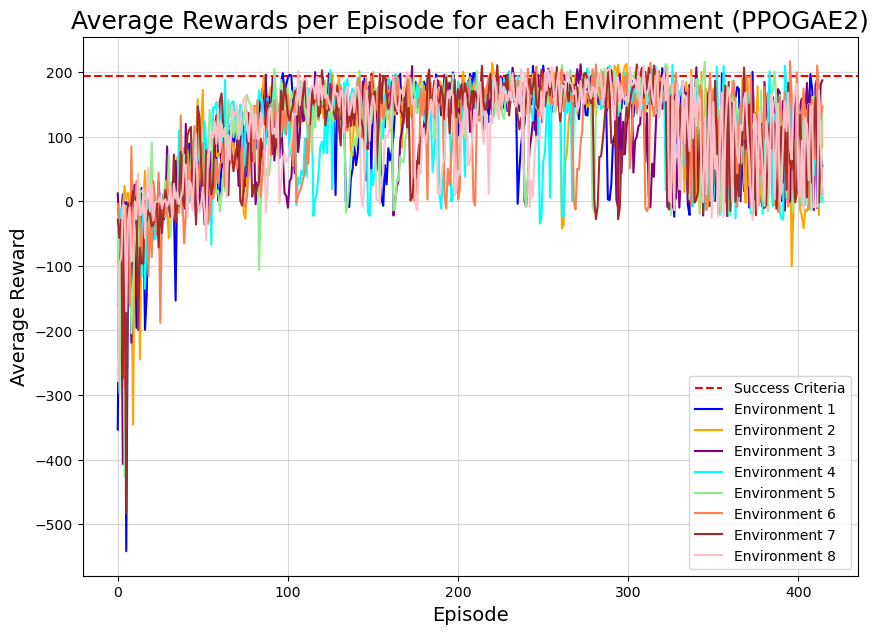

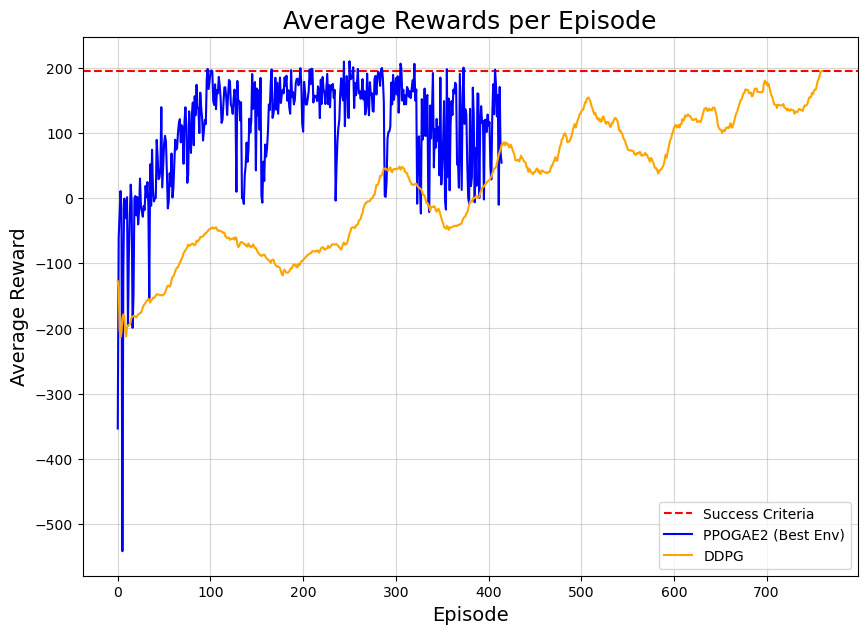

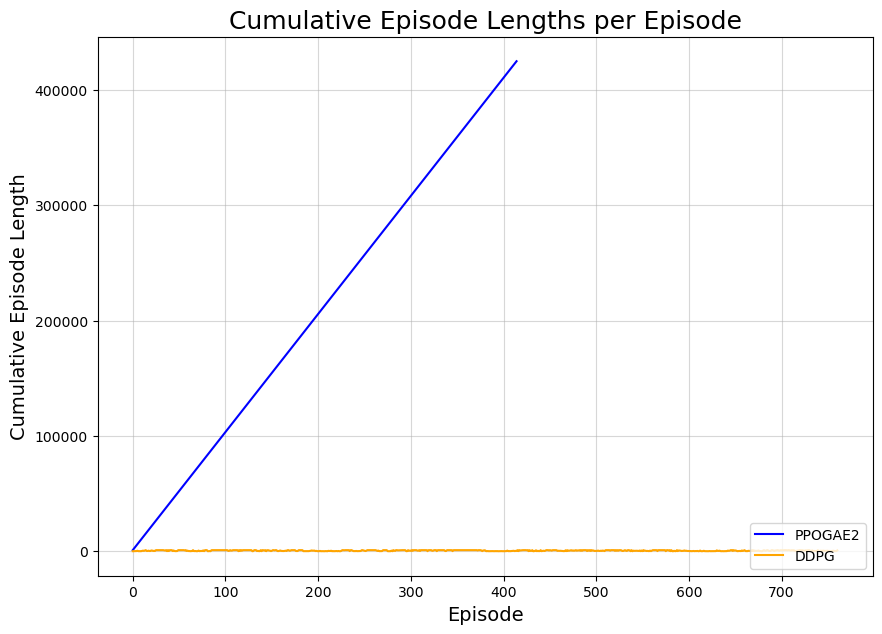

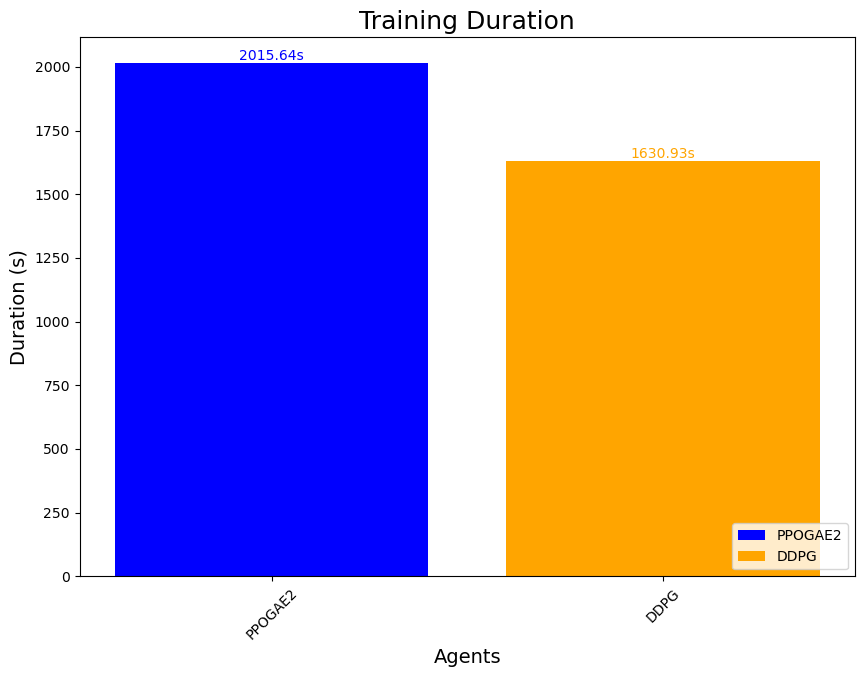

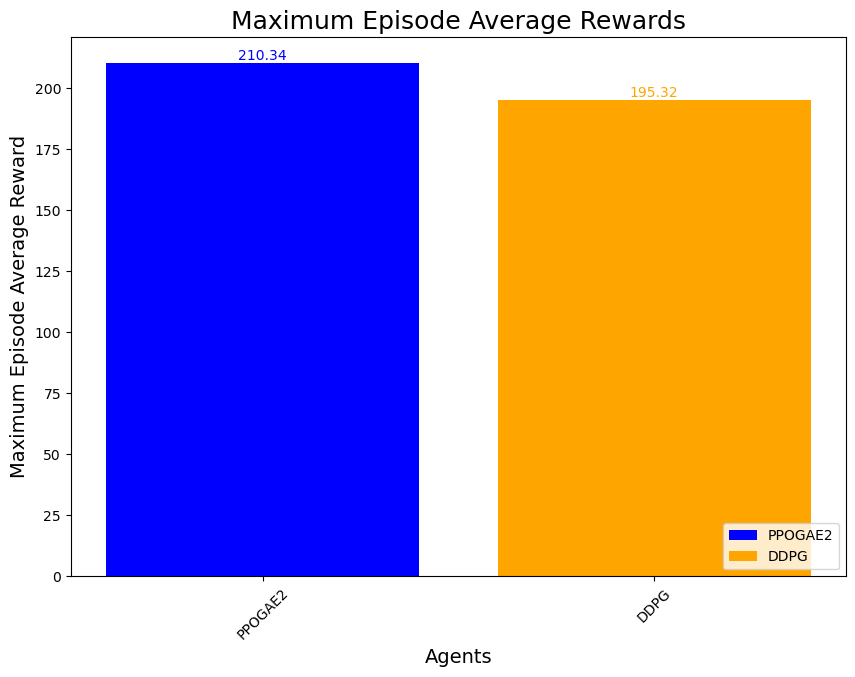

In [27]:
display(ppo_gae2_episode_info, ddpg_episode_info, do_save=True)

**<h5>Closing the environment</h5>**

In [13]:
env.close()